In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import time
from tqdm.auto import trange
import random
from fake_useragent import UserAgent
import os

- ### Extract whole page

In [13]:
car_dict = dict({'title': [],
                 'price': [],
                 'registration': [],
                 'km': [],
                 'displacement': [],
                 'hp': [],
                 'fuel': [],
                 'transmission': [],
                 'category': [],
                 'location': [],
                 'link': []})

In [14]:
for i in trange(120, desc = 'Loop over pages'):
    
    website = 'https://www.car.gr/classifieds/cars/?fs=1&fuel_type=1&fuel_type=2&lang=en&pg=' + str(i)
    response = requests.get(website)
    try:
        assert response.status_code == 200, print(f'Listings Page: {response.status_code}')
    except:
        time.sleep(random.uniform(20, 40))
        continue
    soup = BeautifulSoup(response.content, 'html.parser')
    results = soup.find_all('li', {'class':''})

    for j in trange(len(results), desc = 'Loop over listings', leave=False):
        
        # listing title
        title = results[j].find('h2', {'class': 'title'}).get_text()
        title = title.split('\n')[1]
        # price
        try:
            price = results[j].find('div', {'class': 'price-tag current-price'}).get_text()
            price = ''.join(re.split(r'\W', price)[1:3])
        except:
            # Ask price case
            price = 'Ask price'
        # location
        info = results[j].find_all('span', {'class': ''})[3]
        location = info.get_text()
        

        car_page = 'https://www.car.gr' + results[j].find('a', {'class': 'row-anchor'})['href'] + '?lang=en'
        car_response = requests.get(car_page,
                                    headers = {'User-Agent':UserAgent().random})
        time.sleep(5)
        try:
            assert car_response.status_code == 200, print(f'Car Page: {car_response.status_code}')
        except:
            time.sleep(random.uniform(25, 45))
            if car_response.status_code == 429:
                break
            else:
                continue

        soup = BeautifulSoup(car_response.content, 'html.parser')
        car_results = soup.find_all('div', {'class': 'desktop-right-side', 'class': 'box-icon-text-container'})
        if len(car_results) != 0:
            registration = car_results[0].get_text().split('    ')[2]
            km = car_results[1].get_text().split('    ')[2]
            fuel = car_results[2].get_text().split('    ')[2]
            if 'Petrol' in fuel or 'Diesel' in fuel:
                try:
                    displacement = car_results[3].get_text().split('    ')[2].split(' / ')[0]
                    hp = car_results[3].get_text().split('    ')[2].split(' / ')[1]
                    transmission = car_results[4].get_text().split('    ')[2]
                    category = car_results[5].get_text().split('    ')[2]

                    car_dict['title'].append(title)
                    car_dict['price'].append(price)
                    car_dict['registration'].append(registration)
                    car_dict['km'].append(km)
                    car_dict['displacement'].append(displacement)
                    car_dict['hp'].append(hp)
                    car_dict['fuel'].append(fuel)
                    car_dict['transmission'].append(transmission)
                    car_dict['category'].append(category)
                    car_dict['location'].append(location)
                    car_dict['link'].append(car_page)
                except:
                    continue
        # Waiting time before changing car page 
        time.sleep(random.uniform(7, 14))
    # Waiting time before changing listings page 
    time.sleep(random.uniform(50, 70))

Loop over pages:   0%|          | 0/120 [00:00<?, ?it/s]

Loop over listings:   0%|          | 0/26 [00:00<?, ?it/s]

Loop over listings:   0%|          | 0/26 [00:00<?, ?it/s]

Car Page: 403
Car Page: 429


Loop over listings:   0%|          | 0/26 [00:00<?, ?it/s]

Car Page: 429


Loop over listings:   0%|          | 0/26 [00:00<?, ?it/s]

Car Page: 429


Loop over listings:   0%|          | 0/26 [00:00<?, ?it/s]

Car Page: 429


KeyboardInterrupt: 

In [15]:
df = pd.DataFrame(car_dict).iloc[1:, :]
for i in range(1,100):
    file = f'listings_{i}.csv'
    if not os.path.isfile(file):
        df.to_csv(file)
        break

In [18]:
df.shape

(0, 11)

In [19]:
dfs = []
for i in range(1, 100):
    file = f'listings_{i}.csv'
    try:
        df = pd.read_csv(file, index_col = 0)
        dfs.append(df)
    except:
        break

df  = pd.concat(dfs, axis = 0)

In [20]:
df.shape

(6845, 11)

In [21]:
df.drop_duplicates(keep = 'last', inplace = True)
df.shape

(5046, 11)

In [23]:
df['registration'] = [x[:-1] for x in df['registration'].values]
df['km'] = [x[:-1] for x in df['km'].values]
df['hp'] = [x[:-1] for x in df['hp'].values]
df['fuel'] = [x[:-1] for x in df['fuel'].values]
df['transmission'] = [x[:-1] for x in df['transmission'].values]
df['category'] = [x[:-1] for x in df['category'].values]

In [24]:
df.tail()

,title,price,registration,km,displacement,hp,fuel,transmission,category,location,link
64,Mercedes-Benz A 180 '17 1.5D Automatic Urban...,18500,01/2017,175.000 km,1.500 cc,109 bhp,Diesel,Automatic,Compact/Hatchback,KORYDALLOS 18121,https://www.car.gr/classifieds/cars/view/33076...
65,Volkswagen Polo '01,123,01/2001,100 km,1.400 cc,75 bhp,Petrol,Manual,Limousine/Sedan,VOLOS 38000,https://www.car.gr/classifieds/cars/view/31691...
66,Toyota Aygo '19 1.0 x-trend x-shift,11300,10/2019,76.000 km,998 cc,72 bhp,Petrol,Manual,Compact/Hatchback,KALLITHEA 17673,https://www.car.gr/classifieds/cars/view/33091...
67,Toyota Aygo '18 1.0 x-trend x-shift,9700,04/2018,49.000 km,998 cc,69 bhp,Petrol,Manual,Compact/Hatchback,KALLITHEA 17673,https://www.car.gr/classifieds/cars/view/33085...
68,Toyota Aygo '20,10500,12/2020,48.000 km,998 cc,72 bhp,Petrol,Manual,Compact/Hatchback,KALLITHEA 17673,https://www.car.gr/classifieds/cars/view/33077...


In [25]:
df['category'].unique()

array(['Manual', 'Automatic', 'Semi-automatic', 'Other',
       'Compact/Hatchback', 'Coupe-Sport', '4x4/Jeep/Suv',
       'Commercial Passenger', 'Crew Cab/Pickup', 'Van/Mini Bus',
       'Limousine/Sedan', 'Combi/Caravan', 'Convertible/Roadster',
       'Race Car'], dtype=object)

In [26]:
df.groupby(['category']).size()

category
4x4/Jeep/Suv             576
Automatic                307
Combi/Caravan            149
Commercial Passenger      81
Compact/Hatchback       1151
Convertible/Roadster     103
Coupe-Sport              396
Crew Cab/Pickup           44
Limousine/Sedan          345
Manual                  1071
Other                    165
Race Car                  13
Semi-automatic            10
Van/Mini Bus             110
dtype: int64

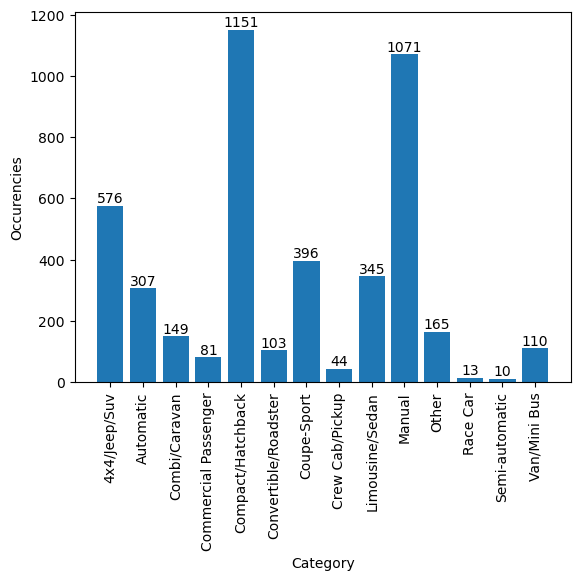

<Figure size 1000x1500 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt

plt.bar(df.groupby(['category']).size().index, df.groupby(['category']).size().values)
for i in range(len(df.groupby(['category']).size().index)):
    plt.text(i, df.groupby(['category']).size().values[i] + 10, df.groupby(['category']).size().values[i], ha = 'center')
plt.xlabel('Category')
plt.ylabel('Occurencies')
plt.xticks(rotation = 90)
plt.figure(figsize=(10,15))
plt.tight_layout();

In [28]:
# try:
#     registration = car_results[2].get_text().split(' ')[-1]
# except:
#     registration = None
# try:
#     km = car_results[3].get_text().split(' ')[2]
# except:
#     km = None
# try:
#     displacement = car_results[5].get_text().split(' ')[4]
# except:
#     displacement = None
# try:
#     hp = car_results[5].get_text().split(' ')[7]
# except:
#     hp = None
# try:
#     fuel = car_results[4].get_text().split(' ')[-1]
# except:
#     fuel = None
# try:
#     transmission = car_results[6].get_text().split(' ')[-1]
# except:
#     transmission = None
# try:
#     category = car_results[7].get_text().split(' ')[-1]
# except:
#     category = None

# info = results[j].find('div', {'class':'d-flex justify-content-between'}).get_text().split('\n  ')

# try:
#     location = info[2].split('  ')
#     location = location[0].split(' ')[1:]
#     location = ' '.join(location)
# except:
#     location = None